# Chap02 - 머신러닝 프로젝트 처음부터 끝까지


### **목차**

1. 실제 데이터로 작업하기

2. 큰 그림 보기 

3. 데이터 가져오기   
    3.1. 설정  
    3.2. 데이터 불러오기  
    3.3. 데이터 구조 훑어보기  
        1) head(), info(), describe(), value_counts(), 히스토그램
    3.4. test set 만들기
        1) np.random.permutation
        2) zlib의 crc32
        3) sklearn의 train_test_split
        4) **sklearn의 StratifiedShuffleSplit**
        5) Random / Stratified Sampling 비교 
        
4. 데이터 탐색 및 시각화  
    4.1. 지리적 데이터 시각화  
    4.2. 상관관계 조사  
    4.3. 특성 조합 (feature combination) - 탐색작업    


5. 머신러닝 알고리즘을 위한 데이터 전처리    
    5.1. 데이터정제 (결측값 처리)
        1) 해당 행 삭제 
        2) 특성(feature) 삭제
        3) **median 값으로 대체 (SimpleImputer)**
    5.2. 텍스트와 범주형 특성 다루기
        1) OrdinalEncoder
        2) **OneHotEncoder**
    5.3. 나만의 변환기 
        1) feature combination 해주는 변환기
    5.4. 특성 스케일링 (feature scaling) 
        1) MinMaxScaler
        2) **StandardScaler**
    5.5. 변환 파이프라인 
        1) 숫자형 데이터 전처리 파이프라인
        2) ColumnTransformer (전체 데이터 전처리) 
        
6. 모델 선택과 학습
    6.1. Training data를 이용한 모델 평가 
        1) Linear Regression
        2) Decision Tree 
    6.2. Cross Validation을 이용한 모델 평가 
        1) **RandomForestRegressor** 
        
7. 모델 세부 튜닝   
    7.1. **그리드 탐색**  
    7.2. 랜덤 탐색  
    7.3. 최상의 모델과 모델 오차 분석   
    7.4. test set으로 시스템 평가하기       
    
    
8. 추가 자료

## 2.1 실제 데이터로 작업하기

[캘리포니아 주택 가격](http://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html)(California Housing Prices) 데이터셋을 사용한다. 이 데이터셋은 1990년 캘리포니아 인구조사 데이터를 기반으로 만들어진 데이터이다. 

## 2.2 큰 그림 보기

캘리포니아 주택 가격 데이터는 캘리포니아의 블록 그룹(block group)마다 인구(population), 중간 소득(median income), 중간 주택 가격(median housing price)등을 담고 있다. 

### 2.2.1 문제 정의

데이터 분석의 목적을 먼저 정하는 것이 가장 중요하다. 분석 목적에 따라 어떠한 데이터 전처리가 필요하며, 어떠한 머신러닝 모델을 써야할지가 결정되기 때문이다. 

#### 파이프라인

데이터 처리 컴포넌트(component)들이 연속되어 있는 것을 데이터 파이프라인(pipeline)이라고 한다. 즉, 각 컴포넌트들은 데이터를 추출해 목적에 맞게 처리하고 처리한 결과를 다른 컴포넌트나 저장소에 보내는 일련의 과정들을 데이터 파이프라인이라고 한다.

캘리포니아 주택 가격 데이터셋을 가지고 학습시켜 다른 데이터가 주어졌을 때 구역의 중간 주택 가격을 예측하는 모델을 만들어 보자.

이번 예제에서는 **다변량 회귀**(multivariate regression)을 이용해 모델링 한다.

### 2.2.2 성능 측정 지표 선택

회귀 문제의 대표적인 성능 지표는 **평균 제곱근 오차**(RMSE, Root Mean Square Error)이다.

$$
\text{RMSE}(\mathbf{X}, h) = \sqrt{\frac{1}{m} \sum^{m}_{i=1}{\left( h \left(\mathbf{x}^{(i)} \right) - y^{(i)} \right)^{2}}}
$$

## 2.3 데이터 가져오기

### 2.3.1 설정

In [1]:
import os
import numpy as np

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
sn.set()

# 한글출력
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

### 2.3.2 데이터 불러오기

In [2]:
#파일 디렉토리 생성 후 다운로드
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [8]:
housing = load_housing_data()

위 코드를 실행하지 않고 직접 파일을 저장해 데이터프레임으로 불러와도 무방하다.

In [2]:
import pandas as pd

housing = pd.read_csv('../datasets/housing/housing.csv')


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### 2.3.3 데이터 구조 훑어보기

In [10]:
#상위 5행을 보여준다. 
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


각 행은 캘리포니아의 한 구역(district)를 나타낸다. 데이터가 10개의 attribute으로 구성되어 있음을 확인할 수 있다. 

In [15]:
# 각 열(attribute)에 대하여 데이터 유형, nonnull value 등을 확인할 수 있다. 
display(housing.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


None

데이터에 총 20,640개의 샘플이 있음을 확인할 수 있다. total_bedrooms attribute의 경우 nonnull value가 20,433개로 결측값이 존재한다. 
ocean_proximity를 제외하고 나머지 attribute은 모두 수치형 데이터이다. 

In [12]:
#수치형 데이터에 대한 summary를 제공한다.
display(housing.describe())

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


각 attribute에 속한 샘플의 개수, 각 attribute의 평균, 표준편차(std), 최소/최대값, 사분위수(quartile) 등을 볼 수 있다. 

In [13]:
#범주형 데이터인 ocean_proximity attribute에 포함된 카테고리 종류를 확인 가능하다.
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

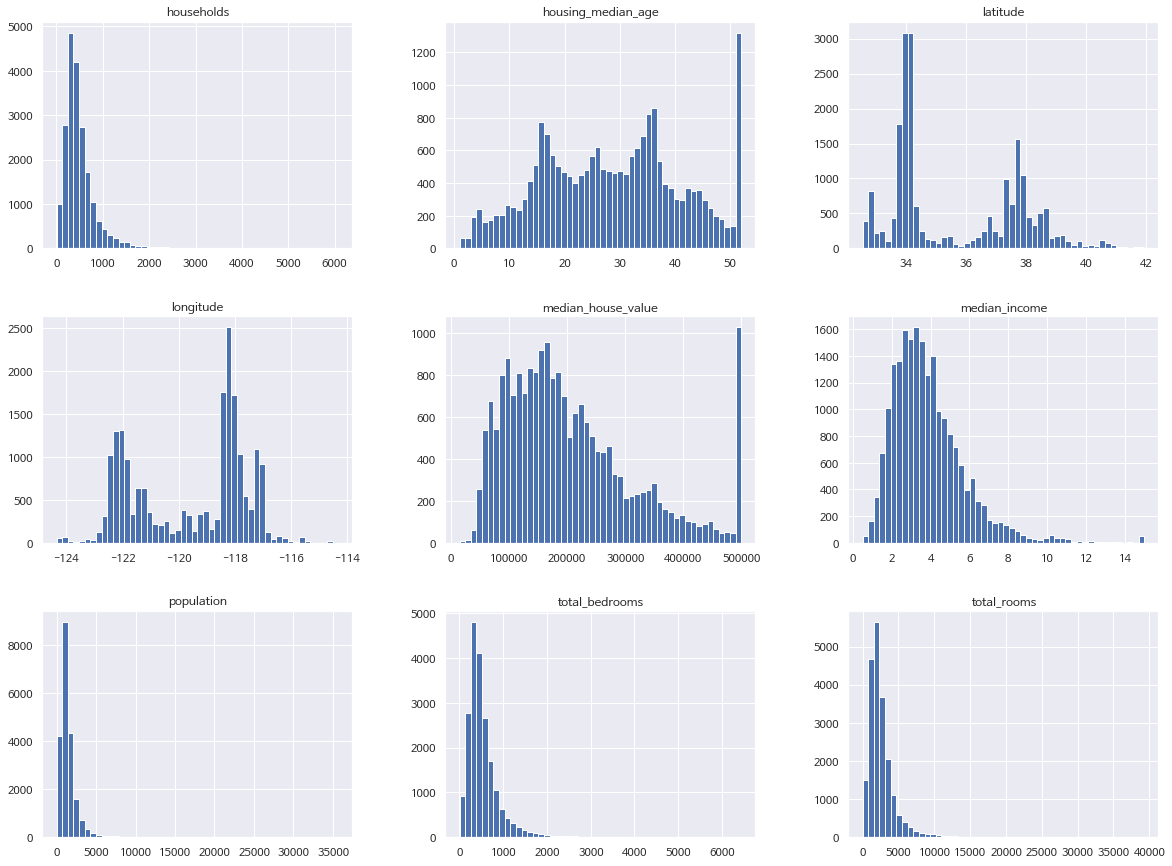

In [14]:
#데이터프레임의 수치형 데이터인 attribute에 대하여 히스토그램을 그려준다. 
housing.hist(bins=50, figsize=(20, 15))
plt.show()

위 히스토그램에서 다음과 같은 사항을 확인할 수 있다.   
1) median income은 US dollar 단위로 작성되어 있지 않다 (만 달러 단위로 작성되어있다).    
     -참고로 median income, housing median age, median house value모두 전처리된 값이다(상한선이 정해져있다).   
2) attribute마다 scale에 차이가 있다.   
3) tail-heavy한 히스토그램이 많다. 

### 2.3.4 테스트 세트 만들기

데이터를 직접 보고 test set을 정하면 bias가 있을 수 있다. 따라서 아래 코드를 통해 무작위로 test set을 생성한다. 

#### 1) np.random.permutaion을 이용해 Train/Test set 나누기

numpy에서 무작위로 test set을 생성할 경우, 코드 실행마다 test set이 바뀔 수 있다. 이를 방지하기 위해서 시드값(seed)를 정해준다. 

>컴퓨터에서 무작위로 생성되는 수는 사실 무작위가 아니라, 어떤 특정한 시작 숫자(seed)를 정해 주면 컴퓨터가 정해진 알고리즘에 의해 마치 난수처럼 보이는 수열을 생성하는 것이다. 따라서 시드값을 정해주면 이후 생성되는 난수(random number)는 예측 가능하다. 따라서 코드 결과를 재현하고 싶을 경우 난수 생성 이전에 시드값을 정하면 된다.  


In [16]:
np.random.seed(42)    # 난수(random number) 생성 시 실행마다 test set이 바뀌지 않도록 시드값을 정해줌
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [17]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [18]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


#### 2) zlib의 crc32를 이용한 Train/Test set 나누기

np.random.permutation을 이용하면 데이터가 업데이트될 경우 test set이 바뀔 수 있다는 문제가 있다.   

이 문제를 해결하는 방법 중 하나는, 각 instance의 identifier에 대한 hash를 계산하여 이용하는 것이다. instance의 hash가 maximum hash value의 20%보다 작거나 같다면 그 instance를 test set에 포함시키는 방식으로 train/test set을 나눌 수 있다.  

In [19]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [20]:
housing_with_id = housing.reset_index()  # 'index'열이 추가된 df가 반환됨
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [21]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
5,5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY
16,16,-122.27,37.85,52.0,1966.0,347.0,793.0,331.0,2.7750,152500.0,NEAR BAY
23,23,-122.27,37.84,52.0,1688.0,337.0,853.0,325.0,2.1806,99700.0,NEAR BAY


이와 같이 test set을 선정할 경우, identifier (이 경우 row index) 가 변하지 않도록 해야 한다. 

#### 3) sklearn의 train_test_split을 이용한 Train/Test set 나누기

In [22]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [23]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


#### 4) sklearn의 StratifiedShuffleSplit을 이용한 Train/Test set 나누기

Train/Test set이 각 데이터를 대표할 수 있도록 고르게 샘플링 되기 위해서 **계층적 샘플링(stratified sampling)** 을 사용할 수 있다. 계층적 샘플링은 전체 모수를 계층으로 나눠 각 계층마다 샘플링을 하는 방법을 말한다.

캘리포니아 주택가격 데이터셋에서는 Train/Test set을 `median_income`을 기준으로 계층적 샘플링을 통해 Train/Test set을 나눈다.  

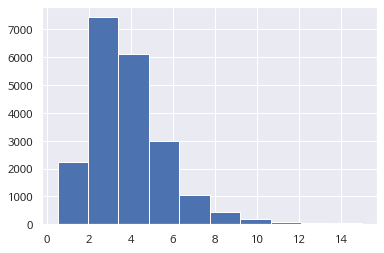

In [25]:
housing['median_income'].hist()

`median_income`은 연속형 데이터이므로 범주형 데이터로 변환해야한다.

In [26]:
# income 카테고리 개수를 제한하기 위해 1.5로 나눔
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True) # 특정 조건에 맞는 데이터 선택 출력 (inplace - 원본 교체)

In [27]:
housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

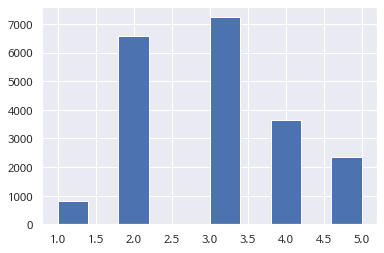

In [28]:
housing["income_cat"].hist()

In [29]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']): # income을 기준으로 housing 데이터셋을 나눔
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [30]:
display(housing['income_cat'].value_counts() / len(housing)) # median income에 대해 원자료를 대표할 수 있도록 고르게 샘플링되었는지 확인
print('='*20)
display(strat_test_set['income_cat'].value_counts() / len(strat_test_set))

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

#### 5) Random과 Stratified Sampling 비교 해보기

In [31]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [32]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1.0,0.039826,0.039729,0.040213,0.973236,-0.243309
2.0,0.318847,0.318798,0.324370,1.732260,-0.015195
3.0,0.350581,0.350533,0.358527,2.266446,-0.013820
4.0,0.176308,0.176357,0.167393,-5.056334,0.027480
5.0,0.114438,0.114583,0.109496,-4.318374,0.127011


In [33]:
# 분석에 필요없는 'income_cat' Column 삭제
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## 2.4 데이터 이해를 위한 탐색과 시각화

In [34]:
# Train set에 대해서만 진행
housing = strat_train_set.copy()

### 2.4.1 지리적 데이터 시각화 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


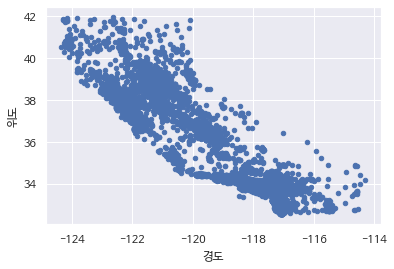

In [35]:
ax = housing.plot(kind='scatter', x='longitude', y='latitude')
ax.set(xlabel='경도', ylabel='위도');

`alpha` 인자를 이용해 데이터 포인트가 밀집된 영역을 표현할 수 있다.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


[Text(0, 0.5, '위도'), Text(0.5, 0, '경도')]

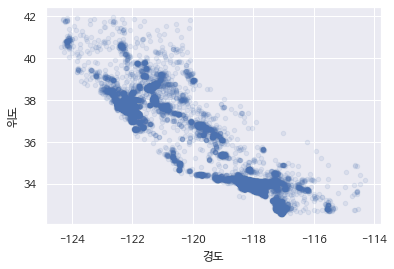

In [36]:
ax = housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
ax.set(xlabel='경도', ylabel='위도')

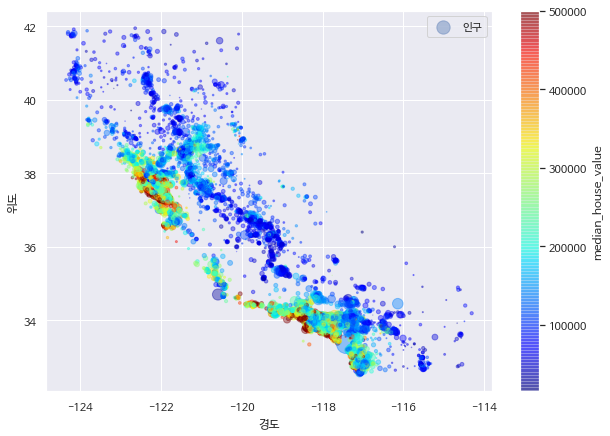

In [37]:
# s = 원의 반지름, c = 색, cmap = predefined color map
ax = housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="인구", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
ax.set(xlabel='경도', ylabel='위도')
plt.legend()

그래프를 통해 **위치**와 **인구 밀도**, **주택 가격**의 관련성이 높음을 알 수 있다. 

### 2.4.2 상관관계 조사

특성(feature)간의 **표준 상관계수**(standard correlation coefficient, 피어슨의 $r$) `corr()`를 사용한다.

In [38]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

상관관계 확인을 위해 pandas의 `scatter_matrix()` 함수를 이용할 수도 있다. 이 함수는 데이터프레임의 모든 attribute에 대하여 모든 attribute에 대한 산점도를 그려준다. 여기서는 몇 가지 attribute만 선정해서 데이터를 탐색해볼 것이다. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000004EF618D248>,
      dtype=object)

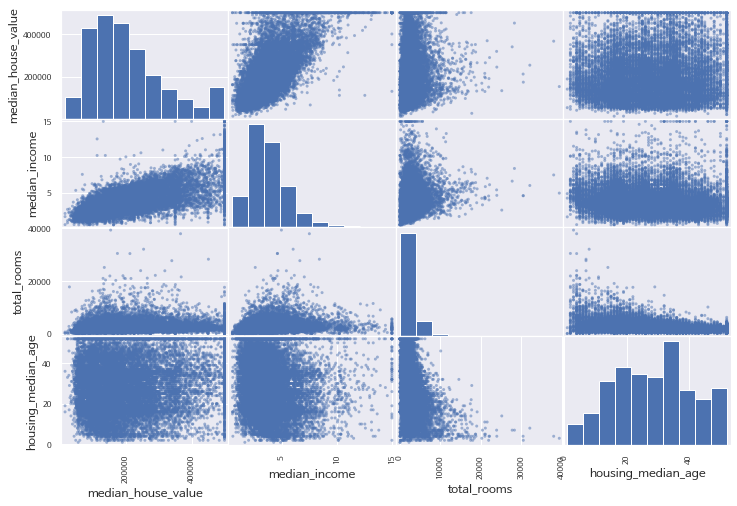

In [39]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

median house value와 median income 간의 상관관계가 가장 두드러지게 나타난다. 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


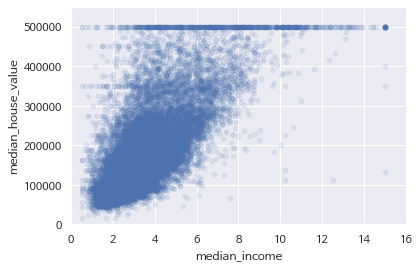

In [40]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000]);

median income과 median house value에 대한 산점도를 확인해보면, 50만 달러 선에 그어진 상한선이 확연히 드러난다. 

### 2.4.3 특성 조합으로 실험

특성들을 조합하여 새로운 특성을 만들어 보자.  

특성 중 `total_rooms`는 그 자체로는 별로 의미있지 않지만 한 주택당 방의 개수로 변환시키면 더 의미있는 자료가 될 것이다. 마찬가지로 `total_bedrooms` 역시 `total_rooms`와 비교해야 더 의미있다. `population` 역시 지역에 존재하는 주택의 수로 나누어 `population_per_household` 특성을 새로 만들어볼 수 있다. 

In [41]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [42]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

새로운 특성을 조합한 후 `median_house_value`와 다른 특성 간의 상관계수를 확인해본 결과 `bedrooms_per_room`과 `rooms_per_household`의 `median_house_value`와의 상관관계가 높아진 것을 확인할 수 있다. 

## 2.5 머신러닝 알고리즘을 위한 데이터 준비

In [43]:
housing = strat_train_set.drop('median_house_value', axis=1)  # predictor와 label(median_house_value) 분리 
housing_labels = strat_train_set['median_house_value'].copy()

### 2.5.1 데이터 정제

`total_bedrooms` 특성에 값이 없는 경우에 대해 데이터 정제를 아래와 같은 방법으로 진행할 수 있다.

 - 해당 구역을 제거
 - 전체 특성을 삭제
 - 어떤 값으로 채움(0, 평균, 중간값 등)
 
아래의 예제 코드는 위의 세 가지 방법을 각각 수행한 샘플 코드이다. `pandas.DataFrame`의 `dropna(), drop(), fillna()`를 이용해 위의 방법을 간단하게 수행할 수 있다.

In [44]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [45]:
# 방법1: null값 삭제 -> dropna()
sample_incomplete_rows.dropna(subset=['total_bedrooms'])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [46]:
# 방법2: 전체 특성(total_bedrooms) 삭제 -> drop()
sample_incomplete_rows.drop('total_bedrooms', axis=1)

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


In [47]:
# 방법3: 어떤 값으로 채우기(median) -> fillna()
median = housing['total_bedrooms'].median()
sample_incomplete_rows['total_bedrooms'].fillna(median, inplace=True)
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


#### SimpleImputer

scikit-learn의 `SimpleImputer`는 누락된 값을 손쉽게 다룰 수 있도록 해준다. `SimpleImputer`를 이용해 Null 값에 중앙값을 채워보도록 하자.

**중앙값(median)** 은 numeric한 데이터 특성에서만 계산되므로 텍스트 특성인 `ocean_proximity`는 제거해준뒤 `Imputer.fit()`을 통해 null 값에 중앙값을 채워준다.

In [49]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")   #인스턴스 생성 시 결측값을 중앙값으로 채울 것임을 명시 
housing_num = housing.drop('ocean_proximity', axis=1)

imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

`Imputer`는 각 특성의 중앙값(median)을 계산한 뒤 그 결과를 `.statistics_`에 저장한다.

In [51]:
print('imputer.statistics_         :', imputer.statistics_)
print('housing_num.median().values :', housing_num.median().values)

imputer.statistics_         : [-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]
housing_num.median().values : [-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


`Imputer`의 `.transform()`을 이용해 Training Set에서 누락된 값을 중앙값으로 바꿀 수 있다. `.transform()`의 반환값은 `NumPy`의 `array`이다.

In [52]:
X = imputer.transform(housing_num)

# NumPy의 array이므로 다시 pandas.DataFrame으로 변환해준다.
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index.values)

# Null값이 median 값으로 잘 채워졌는지 확인
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


### 2.5.2 텍스트와 범주형 특성 다루기

캘리포니아 주택가격 데이터셋에서 `ocean_proximity` 특성처럼 텍스트 형식의 범주형(categorical) 데이터는 머신러닝 알고리즘에 적용하기 위해서는 숫자형 데이터로 바꾸어 줘야 한다.

#### 1) OrdinalEncoder

`Scikit Learn`에서 제공하는 `OrdinalEncoder` 클래스를 사용하면 텍스트 형태의 카테고리명을 숫자형으로 변환할 수 있다. 

In [59]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [61]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [62]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

하지만 이와 같이 범주형 데이터를 숫자로 변환할 경우, ML 알고리즘에서 매핑된 숫자가 가까울수록 더 유사한 카테고리라고 판단될 수 있다는 단점이 있다.  
이를 해결하기 위해 원-핫 인코딩을 실시할 수 있다.

#### 2) OneHotEncoder

scikit-learn은 범주형 데이터를 `OneHotEncoder`를 통해 **원-핫 인코딩(one-hot encoding)**을 할 수 있도록 제공해준다. `OneHotEncoder`의 반환값은 `scipy`의 sparse matrix이다. 그 이유는 카테고리 수가 많을 경우에 one-hot encoding을 하게 되면, 메모리가 많이 필요하기 때문에 이를 방지하고자, 1인 index값만 저장해준다. 이러한 scipy의 sparse matrix를 NumPy 배열로 바꾸려면 `.toarray()`메소드를 사용하면 된다.

In [65]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat) 
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [66]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [67]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### 2.5.3 나만의 변환기

Scikit-Learn에서는 데이터 전처리와 관련하여 다양한 기능들을 제공한다. 하지만, 경우에 따라서는 scikit-learn에서 제공하지 않는 데이터 처리가 필요로 할때가 있다. 

이번에는 직접 데이터 처리를하는 변환기(Transformer) 클래스를 만들어 scikit-learn과 연동해보는 것을 알아보도록 하자.

Scikit-learn은 덕 타이핑(duck typing)을 지원하기 때문에, 새롭게 만들어줄 변환기 클래스 안에 `fit(), transform(), fit_transform()` 메서드를 구현 해주면 된다. 

In [68]:
# 특성을 조합하여 새로운 특성을 만드는 변환기
# 앞에서 논의한 rooms per household, population per household, bedrooms per room 특성을 새로 만드는 변환기 클래스를 만들 것이다.
# 단 bedroom per room의 경우 생성 여부 선택 가능 (생성하는 것이 default)

from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):  # fit()
    def __init__(self, add_bedrooms_per_room=True):  # no *args or **kargs,  침실/방 비율 계산 여부를 hyperparameter로 설정 
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]  #rooms per household 
        population_per_household = X[:, population_ix] / X[:, household_ix] #population per household
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]                                #np.c_ 1차원 배열을 새로로 붙이기 
        else:
            return np.c_[X, rooms_per_household, population_per_household] 
        

In [71]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)  #array 입력

In [72]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs, 
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


### 2.5.4 특성 스케일링

모든 특성의 범위를 같도록 만들어주는 방법으로는 **min-max 스케일링**과 **표준화(standardization)**가 가장 많이 사용된다. 모든 특성의 범위를 같게 해주는 이유는 머신러닝 알고리즘은 입력 데이터 특성들의 스케일이 많이 다를 경우 잘 작동하지 않기 때문이다.

#### 1) sklearn.preprocessing.[MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler)

- `MinMaxScaler`는 모든 특성이 정확하게 0과 1사이에 위치하도록 데이터를 변경함
- 정규화(normalization)이라고도 함

$$
\frac{x - x_{\text{min}}}{x_{\text{max}} - x_{\text{min}}}
$$

In [73]:
from sklearn.preprocessing import MinMaxScaler

data = [[-1, 2], [-0.5, 6], [0, 10], [1, 18]]
scaler = MinMaxScaler()
print(scaler.fit(data))
print("max of data = ", scaler.data_max_)
print("min of data = ", scaler.data_min_)
print("data range = ", scaler.data_range_)
print("<data scaling> \n", scaler.transform(data))
print('[2, 2] minmax scaling =', scaler.transform([[2, 2]]))

MinMaxScaler(copy=True, feature_range=(0, 1))
max of data =  [ 1. 18.]
min of data =  [-1.  2.]
data range =  [ 2. 16.]
<data scaling> 
 [[0.   0.  ]
 [0.25 0.25]
 [0.5  0.5 ]
 [1.   1.  ]]
[2, 2] minmax scaling = [[1.5 0. ]]


#### 2) sklearn.preprocessing.[StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

- 각 특성(feature)의 평균을 0 ($\mu = 0$), 분산을 1 ($\sigma^2 = 1$)인 **표준 정규분포** $N(\mu, \sigma^2) = N(0, 1)$로 변경하여 모든 특성이 같은 크기를 가지게 함
- `StandardScaler`를 구하는 공식은 다음과 같으며, **Z-Score**라고 함

$$
z = \frac{\text{data point} - \text{mean}}{\text{standard deviation}} = \frac{x - \mu}{\sigma}
$$

- `StandardScalere`는 특성의 최소값(min)과 최대값(max) 크기를 제한하지는 않음

In [75]:
from sklearn.preprocessing import StandardScaler

data = [[0, 0], [0, 0], [1, 1], [1, 1]]
scaler = StandardScaler()
print(scaler.fit(data))
print('mean = ', scaler.mean_)
print('variance = ', scaler.var_)
print('z-score = \n', scaler.transform(data))
print('[2, 2] transformation result = ', scaler.transform([[2, 2]]))

StandardScaler(copy=True, with_mean=True, with_std=True)
mean =  [0.5 0.5]
variance =  [0.25 0.25]
z-score = 
 [[-1. -1.]
 [-1. -1.]
 [ 1.  1.]
 [ 1.  1.]]
[2, 2] transformation result =  [[3. 3.]]


### 2.5.5 변환 파이프라인

Scikit-Learn은 데이터 전처리와 관련된 일련의 과정들을 순서대로 처리할 수 있도록 `Pipeline`이라는 클래스를 제공해줘, 데이터 전처리와 관련된 파이프라인을 구성할 수 있다.

In [77]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # name, estimator 쌍으로 구성
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [78]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

지금까지 `housing` 데이터프레임에서 숫자형 데이터(`housing_num`)와 범주형 데이터(`ocean_proximity`)를 따로 다루었다. 
Scikit-Learn 버전 0.20부터 추가된 `ColumnTransformer` 변환기를 사용하면 숫자형 데이터와 범주형 데이터를 함께 파이프라인에 넣을 수 있다. 이 변환기에서는 Pandas DataFrame을 직접 다루는 것이 가능하다. 

In [82]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)  #ocean_proximity를 제외한 column name 리스트
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([     #이름/변환기(transformer)/column name 리스트 로 구성된 튜플의 리스트를 입력값으로
    ("num", num_pipeline, num_attribs), #위에서 구성한 num_pipeline (SimpleImputer, CombinedAttribute)
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

`num_pipeline`의 경우 dense matrix를, `OneHotEncoder()`의 경우 sparse matrix를 리턴한다.   
이 경우 ColumnTransformer는 최종 행렬의 밀도를 고려, 밀도가 일정 수준 아래이면 sparse matrix를, 아니면 dense matrix를 리턴한다. 
이번 예제에서는 dense matrix가 리턴된다. 

#### *Scikit-Learn 이전버전* : pandas의 DataFrame을 처리할 수 있는 변환기 만들기

Scikit-Learn은 Pandas의 DataFrame을 직접 다룰 수 없기 때문에 NumPy의 `array`로 변환해 줘야한다. 따라서, 이를 처리해주는 변환기를 직접 만들어 보고 `Pipeline`에 적용해보자.

In [55]:
'''
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values
'''

In [56]:
'''
num_attribs = housing_num.columns.tolist()
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
])
'''

In [57]:
'''
housing_cat_tr = cat_pipeline.fit_transform(housing)
housing_cat_tr
'''

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

#### 두 파이프라인 합치기

`FeatureUnion`을 이용해 위의 두 파이프라인을 합칠 수 있다. 

In [58]:
'''
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ('num_pipeline', num_pipeline),
        ('cat_pipeline', cat_pipeline),
])
'''

In [59]:
'''
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared
'''

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [60]:
'''
print('housing_prepared.shape :', housing_prepared.shape)
'''

housing_prepared.shape : (16512, 16)


## 2.6 모델 선택과 훈련

### 2.6.1 훈련 세트에서 훈련하고 평가하기

#### 1) Linear Regression

In [83]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [84]:
# 훈련 샘플 몇 개를 사용해 전체 파이프라인을 적용해 보기
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("예측:", lin_reg.predict(some_data_prepared)) #linear regression model의 예측값과 label (실제 값) 비교
print("레이블:", list(some_labels))

예측: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
레이블: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [85]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print('RMSE :', lin_rmse)

RMSE : 68628.19819848923


prediction error가 약 68,628 달러임을 확인할 수 있다. 
median_housing_values가 120,000 달러에서 265,000 달러 사이임을 고려하면 오차가 너무 크다.   
모델이 training data를 underfit할 경우 더 powerful한 모델을 선택하거나, 다른 특성(feature)을 추가하거나, 모델의 constraint를 줄이는 방법이 있다. 여기서는 더 복잡한 모델을 사용해보기로 한다. 

#### 2) DecisionTree

In [86]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [87]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print('RMSE :', tree_rmse)

RMSE : 0.0


오차가 0인 걸 볼 때 training data가 overfit되었을 가능성이 크다.  
이를 알아보기 위해 교차 검증(cross validation)을 사용한다.

### 2.6.2 교차 검증을 사용한 평가

sklearn.model_selection.[cross_val_score]() 함수로 K-Fold Cross-Validation이 구현되어 있다.
- **Parameters:**
    - **estimator**: 평가하기 위한 모델
    - **X**: Training set
    - **y**: Training set Label
    - **cv**: K-fold 에서 K 설정 하는 파라미터 (default=3)  

K-Fold Cross-Validation에서는 training set을 K개의 "fold"로 나눈 후, 9개의 fold로 training 후 1개의 fold로 evaluation을 하는 과정을 10번 거친다. cross_val_score 함수는 이렇게 생성된 10개의 evaluation score의 array를 리턴한다.

In [89]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores) #cross_val_score는 cost function이 아니라 utility function을 사용한다. 

In [90]:
def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준편차:", scores.std())

# DecisionTree
display_scores(tree_rmse_scores)

점수: [67669.73816437 67362.61970456 70229.34328631 68299.62160307
 71291.36213287 75577.59634532 72668.53981039 70226.23940832
 77010.86953522 69438.29976359]
평균: 70977.42297540254
표준편차: 3085.3445235048844


In [91]:
# Linear Regression
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

점수: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
평균: 69052.46136345083
표준편차: 2731.67400179835


Cross validation을 통해 확인한 결과 Decision Tree Model의 심한 overfitting으로 Linear Regression Model보다 더 성능이 좋지 않음을 확인할 수 있다. 

#### 3) RandomForestRegressor

Random Forest는 feature들의 무작위 subset에 대해 Decision Tree를 여러 번 학습시킨 후 예측결과를 평균낸다. 

In [92]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [93]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print('RMSE :', forest_rmse)

RMSE : 18603.515021376355


In [94]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

점수: [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
평균: 50182.303100336096
표준편차: 2097.0810550985693


Linear Regressoin Model이나 Decision Tree보다 성능이 좋음을 볼 수 있다. 학습 데이터에 대한 score보다 cross validation score가 더 높은 것을 볼 때, 여전히 모델이 학습 데이터를 overfitting하고 있다. 

## 2.7 모델 세부 튜닝

학습에 사용할 모델 후보를 정한 이후 세부 튜닝을 해야 한다.   
튜닝을 위해 hyperparameter 값을 바꿔가며 직접 테스트를 해볼 수도 있으나, 아래와 같은 방법들을 사용하는 것이 좋다.

### 2.7.1 그리드 탐색

그리드 탐색(Grid Search)은 테스트해볼 hyperparameter를 주면 가능한 모든 hyperparameter 조합에 대해 cross-validation을 해준다. 아래는 Random Forest에 관해 그리드 탐색을 실시한 것이다.

In [96]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # 하이퍼파라미터 12(=3×4)개의 조합
    # n_estimators는 생성할 트리 개수
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # bootstrap은 False로 하고 6(=2×3)개의 조합
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# 다섯 폴드에서 훈련하면 총 (12+6)*5=90번의 훈련
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', 
                           return_train_score=True, n_jobs=-1)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [97]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

best parameter가 max_feature와 n_estimators의 최대값인 것을 볼 때, 해당 hyperparameter에 더 큰 값을 넣어보면 모델의 성능이 더 높아질 수도 있다. 

In [98]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [99]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.11631261028 {'max_features': 2, 'n_estimators': 3}
55627.099719926795 {'max_features': 2, 'n_estimators': 10}
53384.57275149205 {'max_features': 2, 'n_estimators': 30}
60965.950449450494 {'max_features': 4, 'n_estimators': 3}
52741.04704299915 {'max_features': 4, 'n_estimators': 10}
50377.40461678399 {'max_features': 4, 'n_estimators': 30}
58663.93866579625 {'max_features': 6, 'n_estimators': 3}
52006.19873526564 {'max_features': 6, 'n_estimators': 10}
50146.51167415009 {'max_features': 6, 'n_estimators': 30}
57869.25276169646 {'max_features': 8, 'n_estimators': 3}
51711.127883959234 {'max_features': 8, 'n_estimators': 10}
49682.273345071546 {'max_features': 8, 'n_estimators': 30}
62895.06951262424 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.176157539405 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.40652318466 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52724.9822587892 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [100]:
pd.DataFrame(grid_search.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.112874,0.013387,0.005604,0.000800,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.837622e+09,-4.147108e+09,...,-4.053756e+09,1.519591e+08,18,-1.064113e+09,-1.105142e+09,-1.116550e+09,-1.112342e+09,-1.129650e+09,-1.105559e+09,2.220402e+07
1,0.355634,0.009357,0.014410,0.000490,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.047771e+09,-3.254861e+09,...,-3.094374e+09,1.327062e+08,11,-5.927175e+08,-5.870952e+08,-5.776964e+08,-5.716332e+08,-5.802501e+08,-5.818785e+08,7.345821e+06
2,1.029080,0.023328,0.040228,0.000749,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.689185e+09,-3.021086e+09,...,-2.849913e+09,1.626875e+08,9,-4.381089e+08,-4.391272e+08,-4.371702e+08,-4.376955e+08,-4.452654e+08,-4.394734e+08,2.966320e+06
3,0.164708,0.005392,0.005205,0.000400,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.730181e+09,-3.786886e+09,...,-3.716847e+09,1.631510e+08,16,-9.865163e+08,-1.012565e+09,-9.169425e+08,-1.037400e+09,-9.707739e+08,-9.848396e+08,4.084607e+07
4,0.550563,0.023421,0.014611,0.000801,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.666283e+09,-2.784511e+09,...,-2.781618e+09,1.268607e+08,8,-5.097115e+08,-5.162820e+08,-4.962893e+08,-5.436192e+08,-5.160297e+08,-5.163863e+08,1.542862e+07


### 2.7.2 랜덤 탐색

더 많은 hyperparameter 값에 대해 탐색을 진행하고 싶으면 그리드 탐색이 아닌 랜덤 탐색을 선택하면 된다. 랜덤 탐색에서는 iteration마다 각 hyperparameter에 대해 무작위 값을 선택하여 hyperparameter의 여러 무작위 조합을 평가한다. 


In [101]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', 
                                random_state=42, n_jobs=-1)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [102]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.70756927707 {'max_features': 7, 'n_estimators': 180}
51389.889203389284 {'max_features': 5, 'n_estimators': 15}
50796.155224308866 {'max_features': 3, 'n_estimators': 72}
50835.13360315349 {'max_features': 5, 'n_estimators': 21}
49280.9449827171 {'max_features': 7, 'n_estimators': 122}
50774.90662363929 {'max_features': 3, 'n_estimators': 75}
50682.78888164288 {'max_features': 3, 'n_estimators': 88}
49608.99608105296 {'max_features': 5, 'n_estimators': 100}
50473.61930350219 {'max_features': 3, 'n_estimators': 150}
64429.84143294435 {'max_features': 5, 'n_estimators': 2}


### 2.7.3 최상의 모델과 오차 분석

In [103]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [114]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"] #ColumnTransformer에서 OneHotEncoder에 지정된 이름
cat_one_hot_attribs = list(cat_encoder.categories_[0])
print(cat_one_hot_attribs)

attributes = num_attribs + extra_attribs + cat_one_hot_attribs
print(attributes)

sorted(zip(feature_importances, attributes), reverse =True)

['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']


[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'rooms_per_hhold'),
 (0.053351077347675815, 'bedrooms_per_room'),
 (0.04114379847872965, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.002856474637320158, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

ocean_proximity 카테고리 중 INLAND만이 중요하고 나머지 카테고리는 별로 중요하지 않음을 볼 수 있다. 

### 2.7.4 테스트 세트로 시스템 평가하기

In [115]:
final_model = grid_search.best_estimator_ #grid search를 통해 얻은 최적의 hyperparameter로 설정된 모델을 변수에 저장

X_test = strat_test_set.drop("median_house_value", axis=1) #test set에서 predictor와 label을 분리 
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)  #test set은 fit하지 않으므로 fit_transform()이 아닌 transform()을 사용하는 점 주의 
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [116]:
final_rmse

47730.22690385927

In [117]:
from scipy import stats  # 신뢰구간 확인 
confidence = 0.95
squared_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,
                        loc=squared_errors.mean(),
                        scale=stats.sem(squared_errors)))

array([45685.10470776, 49691.25001878])

## 추가 내용

### 전처리와 예측을 포함한 파이프라인

In [118]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

### joblib을 이용한 모델 저장

In [119]:
my_model = full_pipeline_with_predictor

In [ ]:
from sklearn.externals import joblib
joblib.dump(my_model, "../model/my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("../model/my_model.pkl") # DIFF